In [12]:
%matplotlib inline

import numpy as np
import numpy
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt

In [32]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, np.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atim()")
        temp = temperature[np.newaxis, np.newaxis]
        return np.nansum(self.g[..., np.newaxis]*np.exp(-self.chi[..., np.newaxis]/(constants.k_B*temp)),axis=1)
        
    def compute_excitation(self, temperature):
        pfunc = self.compute_partition_function(temperature)
        #reshape the arrays
        temp = temperature[np.newaxis, np.newaxis]
        g_ratio = self.g[..., np.newaxis]/pfunc[:, np.newaxis]
        chi = self.chi[..., np.newaxis]
        return g_ratio*np.exp(-chi/(constants.k_B*temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure/(constants.k_B*temperature)
        saha_const = ((2*np.pi*constants.m_e*constants.k_B*temp)/constants.h**2)**(3/2)
        nstage = np.zeros_like(partition_function)/units.m**3
        nstage[0] = 1./units.m**3
        
        for r in range(self.n_stages - 1):
            nstage[r+1] = (nstage[r]/electron_density*2*saha_const*partition_function[r+1]/partition_function[r]*
                          np.exp(-self.chi_ion[r+1, np.newaxis]/(constants.k_B*temperature[np.newaxis])))
        
        return nstage/np.nansum(nstage, axis=0)
        
    def compute_populations(self, temperature, electron_pressure):
        
        return (self.compute_excitation(temperature)*self.compute_ionisation(temperature, electron_pressure)[:, np.newaxis])
    
    def plot_payne(self, temperature, electron_pressure):
        
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:,0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:,1].T, 'r--')
        if n_levels > 2:
            ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:,2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1.1)
        ax.set_xlabel('Temperature [K]')
        ax.set_ylabel('Populations')

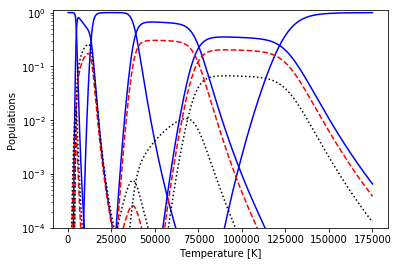

In [33]:
my_atom = Atom("Ca_atom.txt")
#temp = 5000*units.K
temp = np.linspace(100, 175000, 500)*units.K
#my_atom.compute_partition_function(temp)
e_press = 100*units.Pa
my_atom.plot_payne(temp, e_press)

In [40]:
# A simplified Ca atom
ca_ionisation = units.Quantity([0.98, 2.88], unit='aJ')
ca_levels = units.Quantity([[0, 0.301, 0.302, 0.303],
                            [0, 0.271, 0.272, 0.500], 
                            [0, 4.404, 4.050, 4.070]], unit='aJ')
ca_weights = units.Quantity([[1, 1, 3, 5],
                             [2, 4, 6, 2],
                             [1, 1, 3, 5]], unit=None)
temp = 5000*units.K

partition_function = np.sum(ca_weights*np.exp(-ca_levels/(constants.k_B*temp)), axis=1)

partition_function

<Quantity [1.11259945, 2.1970132 , 1.        ]>

In [41]:
boltzmann_pop = (ca_weights / partition_function[:, np.newaxis])*np.exp(-ca_levels/(constants.k_B*temp))

In [42]:
boltzmann_pop

<Quantity [[8.98796059e-01, 1.14820840e-02, 3.39508623e-02,
            5.57709952e-02],
           [9.10326801e-01, 3.59187994e-02, 5.31033484e-02,
            6.51051286e-04],
           [1.00000000e+00, 1.96658453e-28, 9.95190039e-26,
            1.24145644e-25]]>

In [43]:
electron_pressure = units.Quantity(100, unit="Pa")
electron_density = electron_pressure/(constants.k_B*temp)

saha_const = ((2*np.pi*constants.m_e*constants.k_B*temp)/constants.h**2)**(3/2)

pop_stage = np.ones_like(partition_function)
pop_stage[1:] = (1/electron_density*2*partition_function[1:]/partition_function[:-1]*saha_const*np.exp(-ca_ionisation/(constants.k_B*temp)))

#pop_stage[1:] *= pop_stage[:-1]

saha_pop = pop_stage/pop_stage.sum()
saha_pop

<Quantity [3.86016257e-01, 6.13983743e-01, 1.57622530e-13]>